In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif
import src.utils.sequence as utils

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
# import wandb # This is optional 
# wandb.login(host = "https://genentech.wandb.io" )

/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load pre-trained model 

In [12]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/MPRA-dataset:v2/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    checkpoint_path = '../../lightning_logs/version_1/checkpoints/diffusion_epoch=099.ckpt'
    time_schedule = 'artifacts/MPRA-dataset:v2/time_dependent.npz'
config = ModelParameters() 

DEVICE = "cuda:4"

In [13]:
# Load Reward model
from grelu.lightning import LightningModel
reward_model = LightningModel.load_from_checkpoint(
    "../../save_models/eval_reward_models/k562_regressor.ckpt"
)
reward_model.eval()
reward_model.to(DEVICE)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [4]:
# Introduce Two Models

original_model = lightning_dif.load_from_checkpoint(
        checkpoint_path=config.checkpoint_path, 
        weight_file=config.diffusion_weights_file, 
        time_schedule=config.time_schedule, 
        all_class_number=3
    )

original_model = original_model.model
original_model.cuda(device = DEVICE)

ScoreNet_Conditional(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(

# Evaluation 

In [5]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

strength = 1000

condition_0 = torch.tensor([0,]*128, device=DEVICE)
condition_1 = torch.tensor([1,]*128, device=DEVICE)
condition_2 = torch.tensor([2,]*128, device=DEVICE)

allsamples_original_condition_0 = []
allsamples_original_condition_1 = []
allsamples_original_condition_2 = []

original_model.eval()

for t in range(5):
    samples=[]
    samples.append(sampler(original_model,
                        (50,4),
                        new_class = condition_0,
                        class_number = 3,
                        strength = strength, 
                        batch_size = 128,
                        max_time =  4.0,
                        min_time = 1.0/400,
                        time_dilation = 1,
                        num_steps = 100, 
                        eps = 1e-5,
                        speed_balanced = True,
                        device = DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original_condition_0.append(samples)

for t in range(5):
    samples=[]
    samples.append(sampler(original_model,
                        (50,4),
                        new_class = condition_1,
                        class_number = 3,
                        strength = strength, 
                        batch_size = 128,
                        max_time =  4.0,
                        min_time = 1.0/400,
                        time_dilation = 1,
                        num_steps = 100, 
                        eps = 1e-5,
                        speed_balanced = True,
                        device = DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original_condition_1.append(samples)

for t in range(5):
    samples=[]
    samples.append(sampler(original_model,
                        (50,4),
                        new_class = condition_2,
                        class_number = 3,
                        strength = strength, 
                        batch_size = 128,
                        max_time =  4.0,
                        min_time = 1.0/400,
                        time_dilation = 1,
                        num_steps = 100, 
                        eps = 1e-5,
                        speed_balanced = True,
                        device = DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original_condition_2.append(samples)

100%|██████████| 100/100 [00:01<00:00, 61.76it/s]


In [6]:
allsamples_condition_0 = np.concatenate(allsamples_original_condition_0, axis=1)[0,:,:,:]
allsamples_condition_1 = np.concatenate(allsamples_original_condition_1, axis=1)[0,:,:,:]
allsamples_condition_2 = np.concatenate(allsamples_original_condition_2, axis=1)[0,:,:,:]


In [7]:
allsamples_condition_0.shape
# print(allsamples_condition_0)

(640, 50, 4)

In [8]:
rewards_condition_0 = []
data_loader = torch.utils.data.DataLoader(
        allsamples_condition_0.astype("float32"), 
        batch_size=128 , 
        num_workers=0
    )
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    # batch = (batch < 0.5) * torch.zeros_like(batch)
    
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    rewards_condition_0.append(reward_model(batch).detach().cpu() ) 

rewards_condition_0 = np.concatenate(rewards_condition_0)

In [9]:
rewards_condition_1 = []
data_loader = torch.utils.data.DataLoader(
        allsamples_condition_1.astype("float32"), 
        batch_size=128 , 
        num_workers=0
    )
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    rewards_condition_1.append(reward_model(batch).detach().cpu() ) 

rewards_condition_1 = np.concatenate(rewards_condition_1)

In [10]:
rewards_condition_2 = []
data_loader = torch.utils.data.DataLoader(
        allsamples_condition_2.astype("float32"), 
        batch_size=128 , 
        num_workers=0
    )
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    rewards_condition_2.append(reward_model(batch).detach().cpu() ) 

rewards_condition_2 = np.concatenate(rewards_condition_2)

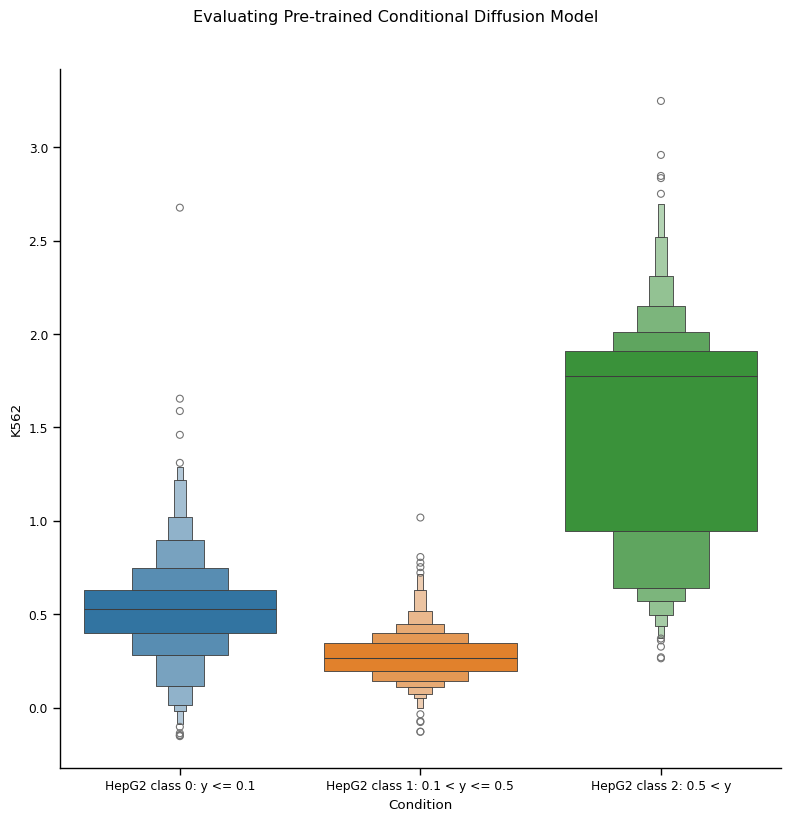

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

compare = np.concatenate((rewards_condition_0[:,0], 
                          rewards_condition_1[:,0], 
                          rewards_condition_2[:,0]), axis= 0)

type1 = ['HepG2 class 0: y <= 0.1' for i in range(len(rewards_condition_0[:,0] ))]
type2 = ['HepG2 class 1: 0.1 < y <= 0.5' for i in range(len(rewards_condition_1[:,0] ))]
type3 = ['HepG2 class 2: 0.5 < y' for i in range(len(rewards_condition_2[:,0] ))]

type = type1 + type2 + type3

data_dict = {'Condition': type, 'K562': compare[:,0] }
plot_data = pd.DataFrame(data_dict)

sns.set_context("paper")
fig = sns.catplot(data=plot_data, 
                  x = 'Condition', 
                  y =  'K562', 
                  hue = "Condition", 
                  kind = "boxen", 
                  height = 8, 
                )

# Add title
fig.fig.suptitle('Evaluating Pre-trained Conditional Diffusion Model', y=1.02)

plt.tight_layout()

fig.savefig(f"../../media/Eval_pre-trained-model_strength={strength}_k562.png")



